# Utils

In [98]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sc

%matplotlib inline
sns.set()


from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor
from sklearn import base

In [2]:
data_firm_level = pd.read_stata("../data/Firm_patent/data_firm_level.dta")
# data_patent_level = pd.read_stata("../data/Patent_level_data/data_patent_level.dta")
# cites = pd.read_stata("../data/Patent_level_data/USPatent_1926-2010/cites/cites.dta")
# firm_innovation_v2 = pd.read_stata("../data/Patent_level_data/USPatent_1926-2010/firm_innovation/firm_innovation_v2.dta)
# patents_xi = pd.read_stata("../data/Patent_level_data/USPatent_1926-2010/patents_xi/patents_xi.dt)
# patent_values = pd.read_stata("../data/Patent_level_data/Patent_CRSP_match_1929-2017/patent_values/patent_values.dta")
patents_firm_merge = pd.read_stata("../data/Firm_patent/patents_firm_merge.dta")

In [40]:
pat = format_patent_data(patents_firm_merge, keep=["year", "permno", "xi", "patent_class"], na_cols=["patent_class", "xi"])

In [3]:
def get_patent_data(path="../data/Firm_patent/patents_firm_merge.dta"):
    pp_df = patents_firm_merge.copy()
    pp_df["patent_class_int"] = pd.to_numeric(pp_df["patent_class"], errors="coerce")
    pp_df = pp_df.dropna(subset=["patent_class_int", "xi", "tsm", "Tsm", "tcw", "Tcw"])
    pp_df["patent_class_int"] = pp_df["patent_class_int"].astype(int)

    for col in ["fdate", "idate", "pdate"]:
        a = pd.to_datetime(pp_df[col], format="%m/%d/%Y", errors="coerce")
        pp_df[col] = a
    
    pp_df = pp_df.set_index("patnum")

    return pp_df

In [4]:
patent_df = get_patent_data()

In [6]:
def add_dumies(
    df,
    var_to_keep=["idate", "year", "permno", "patent_class_int"] #, "xi", "ncites", "Npats", "Tcw", "Tsm", "tcw", "tsm"]
    ):

    main_df = df[var_to_keep]
    main_df = pd.get_dummies(data=main_df, columns=["patent_class_int"], prefix=["pc"])
    firm_df = main_df.groupby(by=["permno", "year"]
    ).agg({s : 'sum' for s in main_df.columns if s[:2]=="pc"}
    ).reset_index()

    return firm_df

In [57]:
firm_df = add_dumies(patent_df)

In [8]:
firm_df

permno  year  pc_1  pc_2  pc_4  pc_5  pc_7  pc_8  pc_12  pc_14  ...  \
0      10006.0  1950   0.0     0     1     0     0     0      0      0  ...   
1      10006.0  1951   0.0     0     1     2     0     0      0      0  ...   
2      10006.0  1952   0.0     0     0     0     0     0      0      0  ...   
3      10006.0  1953   0.0     0     0     2     0     0      0      0  ...   
4      10006.0  1954   0.0     0     0     1     0     0      0      0  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...    ...    ...  ...   
53800  93236.0  1995   0.0     0     0     0     0     0      0      0  ...   
53801  93236.0  1997   0.0     0     0     0     0     0      0      0  ...   
53802  93252.0  1985   0.0     0     0     0     0     0      0      0  ...   
53803  93252.0  1989   0.0     0     0     0     0     0      0      0  ...   
53804  93287.0  1986   0.0     0     0     0     0     0      0      0  ...   

       pc_715  pc_716  pc_717  pc_718  pc_719  pc_720  pc_725  pc_726  pc_800  \
0         0.0       0       0       0       0       0       0       0     0.0   
1         0.0       0       0       0       0       0       0       0     0.0   
2         0.0       0       0       0       0       0       0       0     0.0   
3         0.0       0       0       0       0       0       0       0     0.0   
4         0.0       0       0       0       0       0       0       0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
53800     0.0       0       0       0       0       0       0       0     0.0   
53801     0.0       0       0       0       0       0       0       0     0.0   
53802     0.0       0       0       0       0       0       0       0     0.0   
53803     0.0       0       0       0       0       0       0       0     0.0   
53804     0.0       0       0       0       0       0       0       0     0.0   

       pc_850  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
53800       0  
53801       0  
53802       0  
53803       0  
53804       0  

[53805 rows x 427 columns]

In [132]:
class AddPast(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, numLags, groupCol='permno', timevar='year', col_prefix='pc_', sufix='lag', set_index=True, dropna=True, filter_rows=True):
        self.numLags = numLags
        self.groupCol = groupCol
        self.timevar = timevar
        self.col_prefix = col_prefix
        self.sufix = sufix
        self.set_index = set_index
        self.dropna = dropna
        self.filter_rows = filter_rows
        
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        tmp = self.X.copy()
        cols = tmp.columns[tmp.columns.str.startswith(self.col_prefix)]

        if self.filter_rows:
            comp = (tmp.groupby([self.groupCol])[self.groupCol].count() > self.numLags).rename('n').reset_index()
            comp = comp[comp.n][self.groupCol]
            tmp = tmp[tmp[self.groupCol].isin(comp)]

        for i in range(1, self.numLags + 1):
            for col in cols:
                tmp[col + '_' + self.sufix  + '_' + str(i)] = tmp.groupby([self.groupCol])[col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)

        if self.set_index:
            tmp = tmp.set_index([self.groupCol, self.timevar])
            
        return tmp.astype(int)

In [ ]:
class AddConcurrence(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, permno, compvar='permno', timevar='year', col_prefix='pc_', prefix='comp'):
        self.permno = permno
        self.compvar = compvar
        self.timevar = timevar
        self.col_prefix = col_prefix
        self.prefix = prefix
        
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        tmp = self.X.copy()
        sub = tmp[tmp[compvar]==permno].drop(columns=[compvar])
        years = sub[self.timevar]
        sub = sub.set_index(self.timevar)
        comps = tmp[compvar].unique()
        cols = tmp.columns[tmp.columns.str.startswith(self.col_prefix)]

        for comp in comps:
            if comp != permno:
                compsub = tmp[tmp[compvar]==comp].drop(columns=[compvar]).set_index(self.timevar)
                tmp[self.prefix  + '_' + str(i) + '_' + col] = tmp.groupby([self.groupCol])[col].shift(i) 

        if self.set_index:
            tmp = tmp.set_index([self.groupCol, self.timevar])
            
        return tmp.astype(int)

In [147]:
c = a.reset_index()
c['permno'].unique()

array([10006., 10014., 10057., ..., 92399., 92903., 92930.])

In [119]:
a = AddPast(numLags=5, dropna=True, set_index=True, filter_rows=True).fit_transform(firm_df)

In [120]:
a

pc_1  pc_2  pc_4  pc_5  pc_7  pc_8  pc_12  pc_14  pc_15  pc_16  \
permno  year                                                                   
10006.0 1955     0     0     0     1     0     0      0      0      0      0   
        1956     0     0     0     0     0     0      0      0      0      0   
        1957     0     0     0     0     0     0      0      0      0      0   
        1958     0     0     0     0     0     0      0      0      0      0   
        1959     0     0     0     0     0     0      0      0      0      0   
...            ...   ...   ...   ...   ...   ...    ...    ...    ...    ...   
92930.0 2002     0     0     0     0     0     0      0      0      0      1   
        2003     0     0     0     0     0     0      0      0      0      1   
        2004     0     0     0     0     0     0      0      0      0      0   
        2005     0     0     0     1     0     0      0      0      0      0   
        2006     0     0     0     0     0     0      0      0      0      0   

              ...  pc_715_lag_5  pc_716_lag_5  pc_717_lag_5  pc_718_lag_5  \
permno  year  ...                                                           
10006.0 1955  ...             0             0             0             0   
        1956  ...             0             0             0             0   
        1957  ...             0             0             0             0   
        1958  ...             0             0             0             0   
        1959  ...             0             0             0             0   
...           ...           ...           ...           ...           ...   
92930.0 2002  ...             0             0             0             0   
        2003  ...             0             0             0             0   
        2004  ...             0             0             0             0   
        2005  ...             0             0             0             0   
        2006  ...             0             0             0             0   

              pc_719_lag_5  pc_720_lag_5  pc_725_lag_5  pc_726_lag_5  \
permno  year                                                           
10006.0 1955             0             0             0             0   
        1956             0             0             0             0   
        1957             0             0             0             0   
        1958             0             0             0             0   
        1959             0             0             0             0   
...                    ...           ...           ...           ...   
92930.0 2002             0             0             0             0   
        2003             0             0             0             0   
        2004             0             0             0             0   
        2005             0             0             0             0   
        2006             0             0             0             0   

              pc_800_lag_5  pc_850_lag_5  
permno  year                              
10006.0 1955             0             0  
        1956             0             0  
        1957             0             0  
        1958             0             0  
        1959             0             0  
...                    ...           ...  
92930.0 2002             0             0  
        2003             0             0  
        2004             0             0  
        2005             0             0  
        2006             0             0  

[31438 rows x 2550 columns]

In [121]:
b = sc.sparse.csr_matrix(a)

# Distribution des brevets selon la classe

In [76]:
def get_class_repartition(firm_df):
    repartition = firm_df[firm_df.columns[pd.Series(firm_df.columns).str.startswith('pc_')]].sum().reset_index()
    repartition['index'] = repartition['index'].str.extract('(\d+)', expand=False).astype(int)
    repartition = repartition.rename(columns={0: 'n_patent', 'index': 'patent_class'}).set_index('patent_class')
    return repartition

In [77]:
repartition = get_class_repartition(firm_df)

In [78]:
repartition

n_patent
patent_class          
1              10884.0
2                695.0
4                463.0
5               1190.0
7                 53.0
...                ...
720             1208.0
725             2071.0
726             3418.0
800             2368.0
850              311.0

[425 rows x 1 columns]

Il y a 10884 dans la classe 1 par exemple.

### Nombre de brevet en fonction de la classe

On voit que le nombre de brevet par classe est hétérogène, il y a certaine classe qui ont un nombre très important de brevet et d'autre qui en ont très peu.

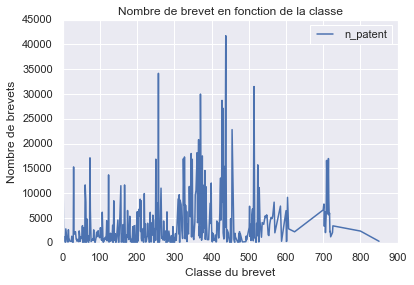

In [103]:
fig, ax = plt.subplots()
repartition.plot(ax=ax)
ax.set_title('Nombre de brevet en fonction de la classe')
ax.set_xlabel('Classe du brevet')
ax.set_ylabel('Nombre de brevets')
plt.show()

Ce serais mieux de faire un barplot mais je n'arrive pas à le faire marcher.

### Histogramme du nombre de brevets par classe

In [158]:
def plot_repartition(repartition, title):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,18))
    fig.suptitle(title, fontsize=16)
    repartition.plot(ax=axs[0])
    axs[0].set_title('Nombre de brevet en fonction de la classe')
    axs[0].set_xlabel('Classe du brevet')
    axs[0].set_ylabel('Nombre de brevets')
    sns.histplot(repartition['n_patent'], ax=axs[1])
    axs[1].set_title('Histogramme du nombre de brevets par classe')
    axs[1].set_xlabel('Nombre de brevets')
    axs[1].set_ylabel('Nombre de classes')
    sns.boxplot(repartition['n_patent'], ax=axs[2])
    axs[2].set_title('Boxplot du nombre de brevets')
    axs[2].set_xlabel('Nombre de brevets')
    plt.show()

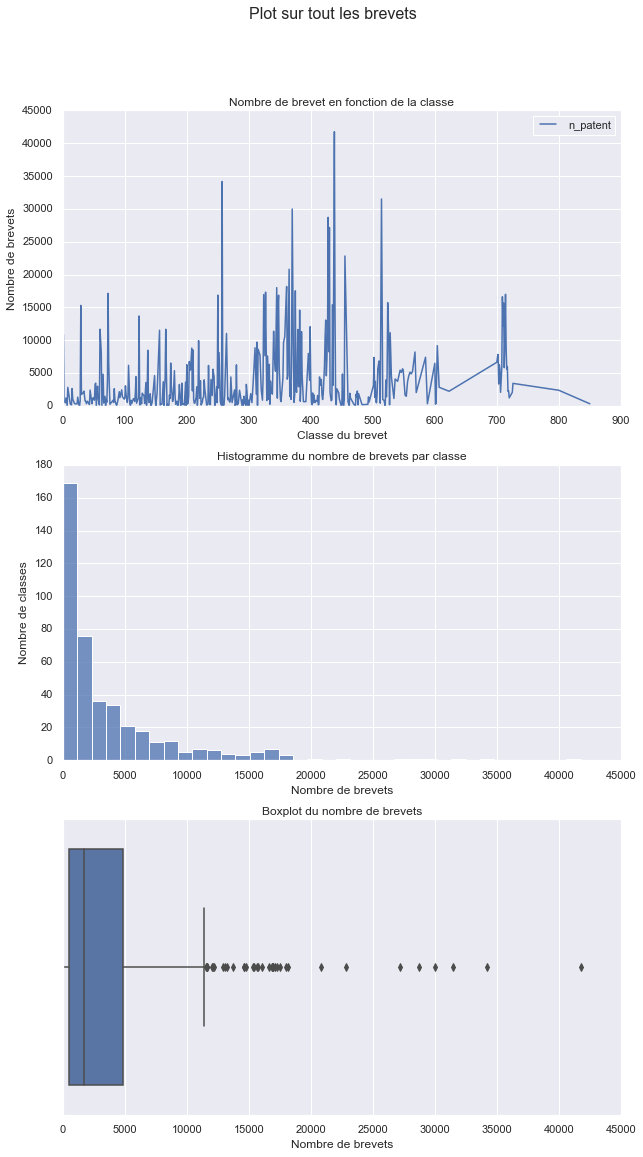

In [159]:
plot_repartition(repartition, 'Plot sur tout les brevets')

On voit qu'il y a beaucoup de classe avec très peu de brevets. Il y a environ 170 dans la première bin.

Il y a 35 classes qui ont moins de 100 brevets au total. 

On peut voir les classes avec le plus de brevets :

In [101]:
repartition.sort_values('n_patent', ascending=False).head(100)

n_patent
patent_class          
438            41755.0
257            34170.0
514            31503.0
370            29981.0
428            28713.0
...                ...
206             5483.0
544             5422.0
205             5416.0
549             5416.0
331             5356.0

[100 rows x 1 columns]

In [97]:
repartition.describe()

n_patent
count    425.000000
mean    3848.543529
std     5483.670043
min        1.000000
25%      502.000000
50%     1723.000000
75%     4864.000000
max    41755.000000

# Repartition sur une année donnée

Prenons 1986 comme exemple.

In [143]:
def get_class_year_repartition(patent_df, year):
    year_repartition = pd.DataFrame()
    year_repartition['n_patent']  = patent_df[patent_df['year']==year].groupby(['patent_class_int']).count()['index']
    year_repartition = year_repartition.reset_index().sort_values('patent_class_int').rename(columns={'patent_class_int' : 'patent_class'}).set_index('patent_class')
    return year_repartition

In [144]:
year_repartition = get_class_year_repartition(patent_df, 1986)

In [147]:
year_repartition

n_patent
patent_class          
1                   11
2                   16
4                    8
5                   16
7                    2
...                ...
717                  4
718                  5
719                  1
720                 12
725                 10

[391 rows x 1 columns]

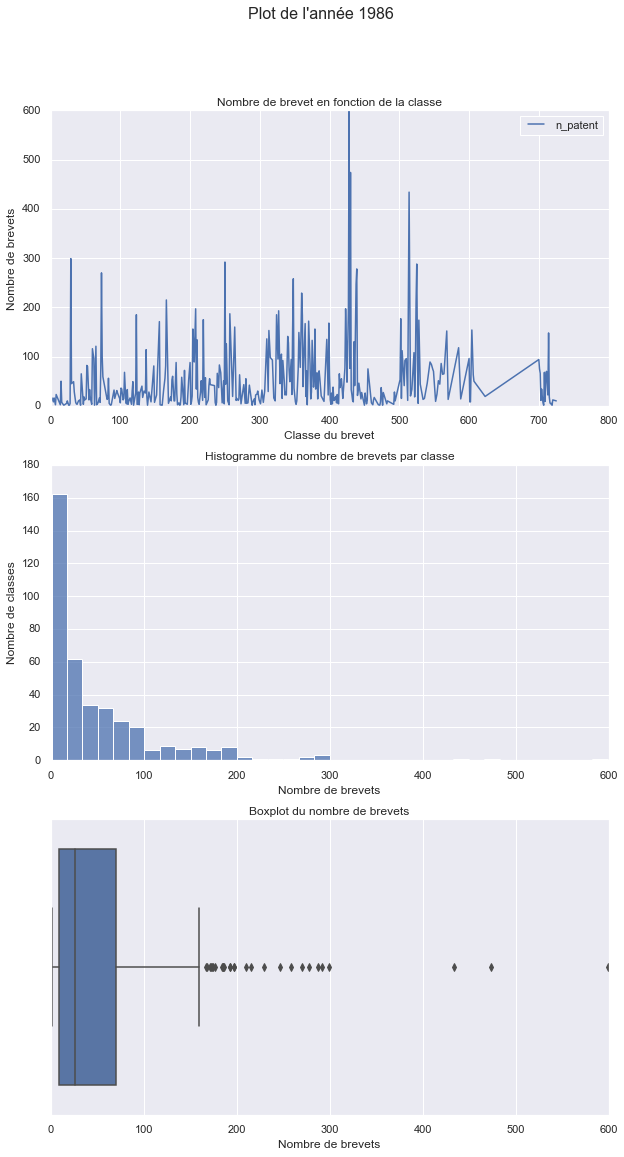

In [160]:
plot_repartition(year_repartition, "Plot de l'année 1986")

La distribution ne change pas trop.

On peut essayer pour quelques autres années :

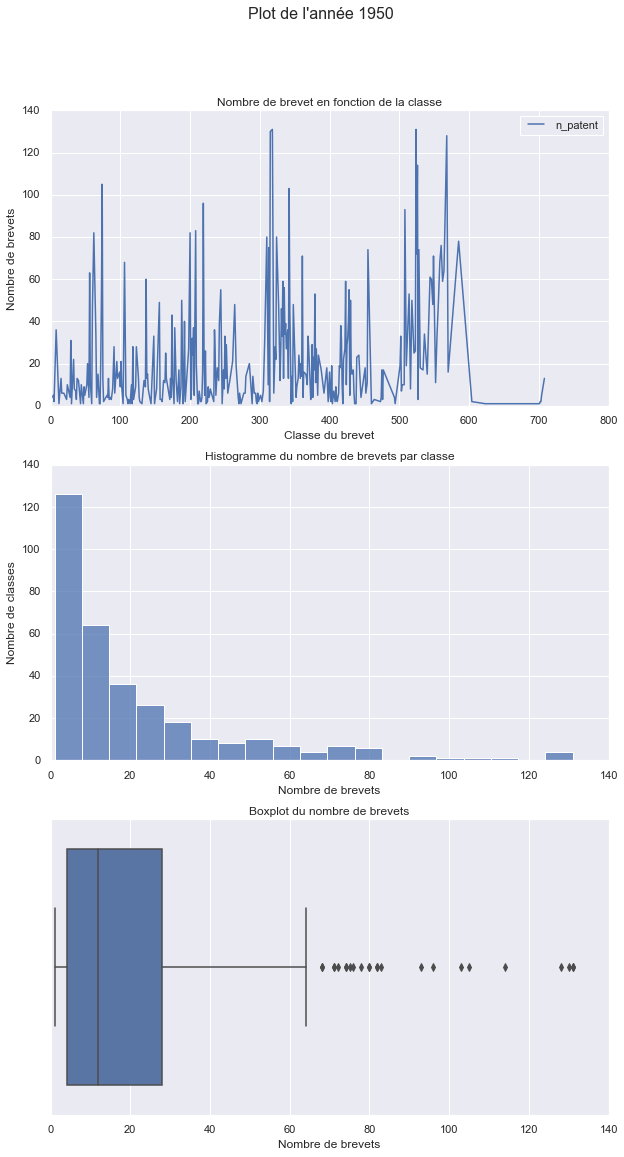

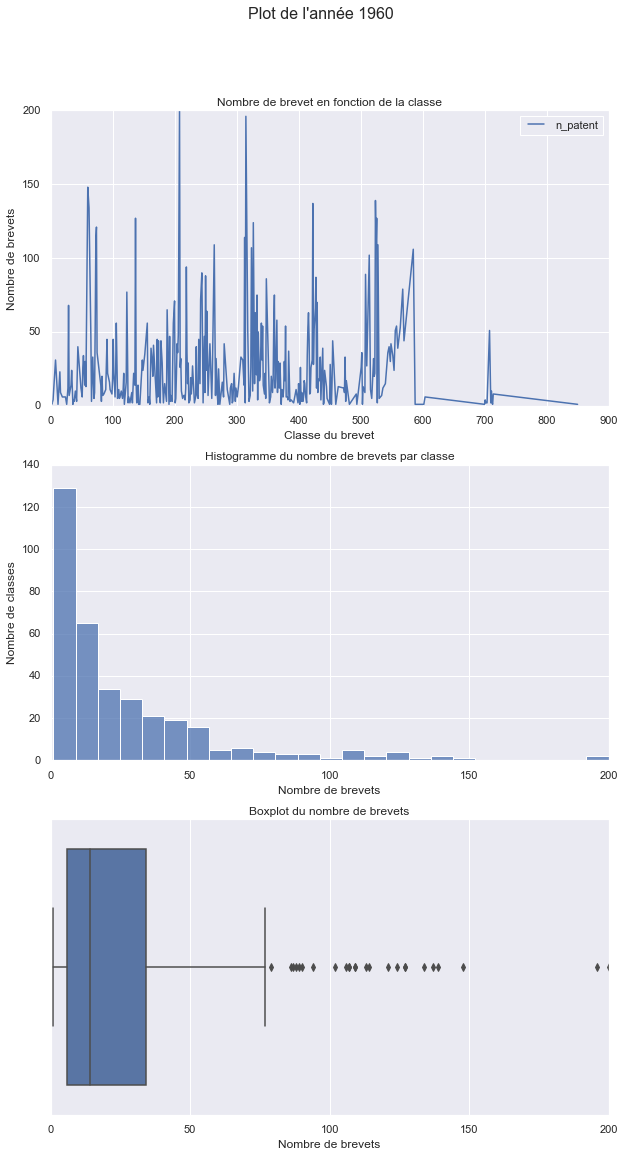

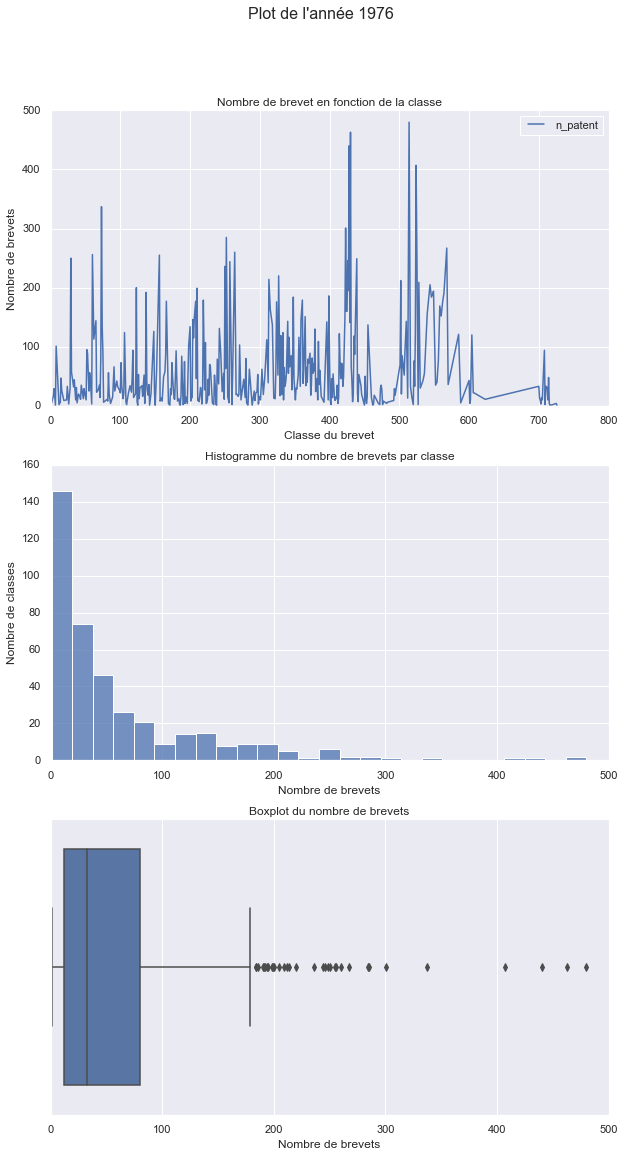

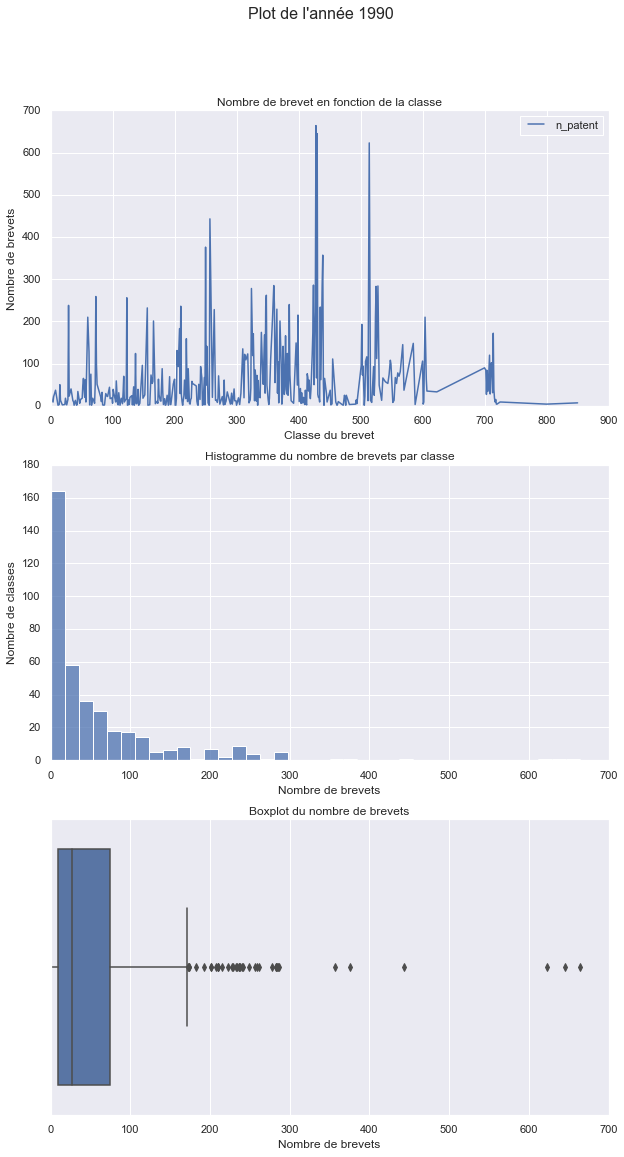

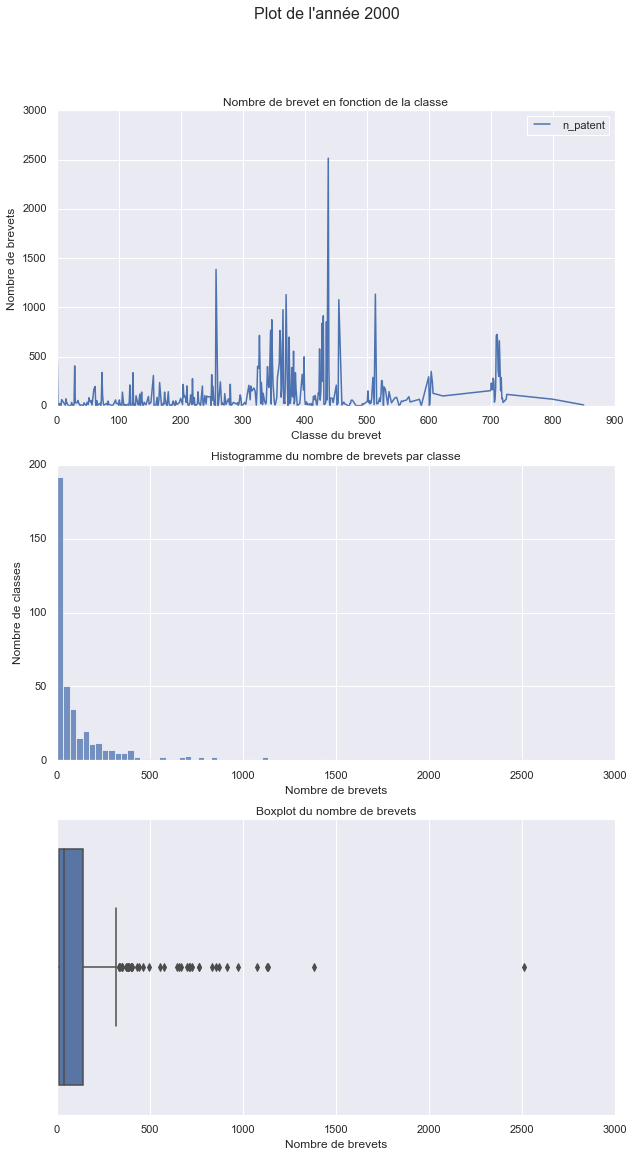

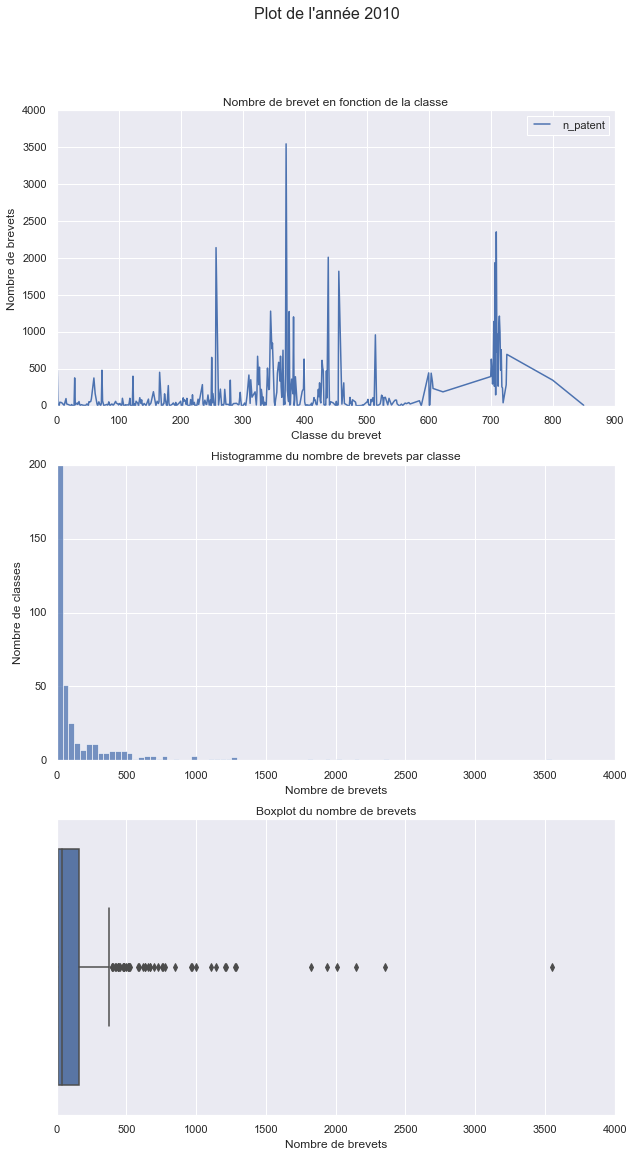

In [162]:
for year in [1950, 1960, 1976, 1990, 2000, 2010]:
    plot_repartition(get_class_year_repartition(patent_df, year), f"Plot de l'année {year}")

On voit que cela evolue avec le temps (il y a plus de classes en 2000 par exemple et les classes majoritaires changent entre 1950 et 2010).

Mais on voit aussi des spécialisations plus on avance dans le temps (pics vers 260, 380, 420, 450, 520, 700). On voit que le pics le plus important change selon les années (évolution de la R&D ?).

# Distribution du nombre de brevets selon les entreprises

In [166]:
def get_firm_repartition(firm_df):
    repartition = firm_df[firm_df.columns[pd.Series(firm_df.columns).str.startswith('pc_')]].sum(axis=1).reset_index()
    repartition = repartition.rename(columns={0: 'n_patent', 'index': 'patent_class'}).set_index('patent_class')
    return repartition

In [170]:
firm_repartition = get_firm_repartition(firm_df)

In [171]:
firm_repartition

n_patent
patent_class          
0                  6.0
1                 25.0
2                 19.0
3                 25.0
4                 20.0
...                ...
53800              2.0
53801              1.0
53802              1.0
53803              1.0
53804              2.0

[53805 rows x 1 columns]

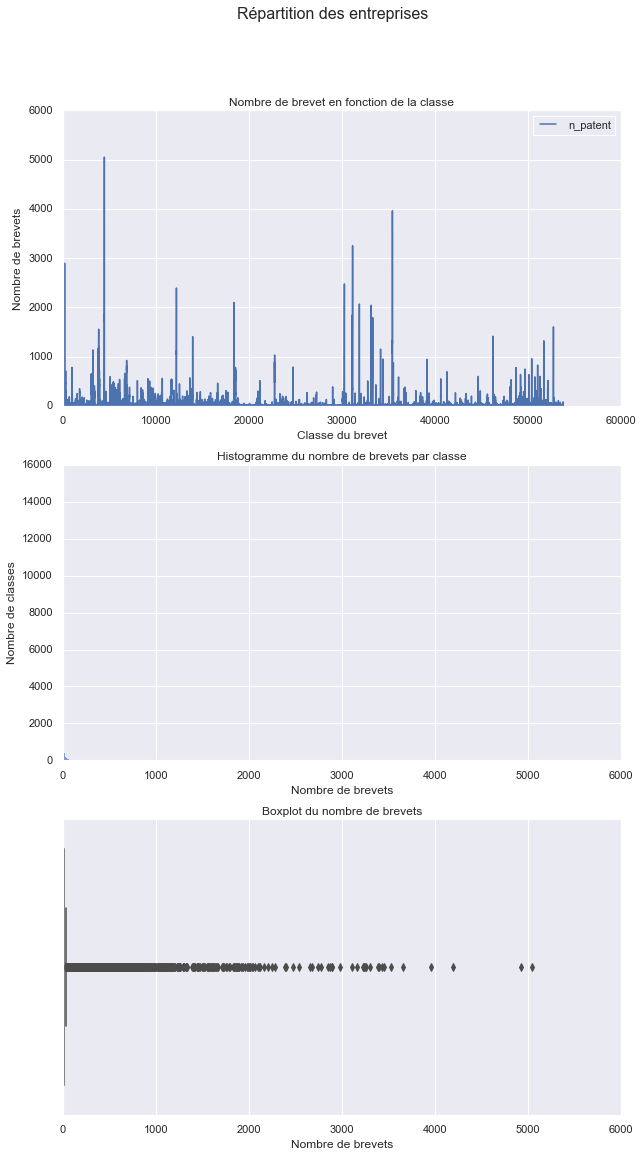

In [173]:
plot_repartition(firm_repartition, 'Répartition des entreprises')